# Imports

In [1]:
# general purpose
import os
import typing
import copy

# Data handling
import bioread
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

# Vizualization
import matplotlib.pyplot as plt
import seaborn as sn

# Utils

In [2]:
class TimeSeries:
    def __init__(self, **kwargs):
        if "biopac_channel" in kwargs:
            self.init_from_biopac_channel(kwargs["biopac_channel"])
        else:
            self.__init_from_data(**kwargs)

    
    def init_from_biopac_channel(self, biopac_channel):
        self.__init_from_data(
            name = biopac_channel.name,
            sampling_frequency = biopac_channel.samples_per_second,
            time_data_length = biopac_channel.point_count,
            time_data = biopac_channel.data,
            measuring_unit = biopac_channel.units
        )

    def __init_from_data(self, **kwargs):
        self.name = kwargs["name"]
        self.sampling_frequency = kwargs["sampling_frequency"]
        self.time_data_length = kwargs["time_data_length"]
        self.time_data = kwargs["time_data"]
        self.measuring_unit = kwargs["measuring_unit"]
    
    def cut_time_data_in_windows(self, window_size):
        return self.__cut_in_chunks_of_n_and_drop_rest(self.time_data, window_size)

    @staticmethod
    def __cut_in_chunks_of_n_and_drop_rest(array, chunk_size):
        result = []
        array_length = len(array)

        for index in range(0, array_length, chunk_size):
            if (index + chunk_size > array_length):
                break
                
            result.append(array[index: index + chunk_size])
        
        return result

    def plot(self):
        time_data_ox_axis = np.linspace(0, self.time_data_length - 1, self.time_data_length)

        plt.figure(figsize=(12,3), dpi= 100, facecolor='w', edgecolor='k')
        plt.plot(time_data_ox_axis, self.time_data,
                color = 'red',
                label="({})".format(self.name)); 
        plt.xlabel("Time(s)")
        plt.ylabel('Amplitude(' + self.measuring_unit + ")")
        plt.legend()

In [3]:
class Spectrum:
    BAND_WAVES_DEFINITIONS = {
        'delta': {'name' : 'Delta wave', 'low' : 1, 'high' : 4, 'color' : 'b'},
        'theta': {'name' : 'Theta wave', 'low' : 4, 'high' : 8, 'color' : 'g'},
        'alpha': {'name' : 'Alpha wave', 'low' : 8, 'high' : 12, 'color' : 'r'},
        'beta': {'name' : 'Beta wave', 'low' : 13, 'high' : 30, 'color' : 'c'},
        'low_gamma': {'name' : 'Low Gamma wave', 'low' : 30, 'high' : 70, 'color' : 'm'},
        'high_gamma': {'name' : 'High Gamma wave', 'low' : 70, 'high' : 150, 'color' : 'y'}
    }
    
    def __init__(self, time_series: TimeSeries):
        self.name = time_series.name
        self.sampling_frequency = time_series.sampling_frequency
        self.spectrum_data_length = time_series.time_data_length
        self.spectrum_data = np.fft.fft(time_series.time_data)
        self.measuring_unit = time_series.measuring_unit
        self.frequencies = np.fft.fftfreq(self.spectrum_data_length, 1 / self.sampling_frequency)

    def band_pass_filter(self, low_cut_off, high_cut_off):
        spectrum_frequencies = self.frequencies

        # cutting the lower frequencies
        filtered_spectrum_data = self.spectrum_data * (np.absolute(spectrum_frequencies) > low_cut_off) 
        
        # cutting the higher frequencies
        filtered_spectrum_data = filtered_spectrum_data * (np.absolute(spectrum_frequencies) < high_cut_off)
        
        return self.new_spectrum(filtered_spectrum_data)

    def new_spectrum(self, new_spectrum_data):
        new_spectrum = copy.deepcopy(self)
        new_spectrum.spectrum_data = new_spectrum_data
        return new_spectrum

    def to_time_series(self):
        time_data = np.real(np.fft.ifft(self.spectrum_data))
        
        return TimeSeries(
            name = self.name,
            sampling_frequency = self.sampling_frequency,
            time_data_length = len(time_data),
            time_data = time_data,
            measuring_unit = self.measuring_unit
        )

    def plot(self, from_index = None, to_index = None):
        spectrum_data = abs(self.spectrum_data[0: int(self.spectrum_data_length / 2)])
        spectrum_x = self.frequencies[0: int(self.spectrum_data_length / 2)]

        if from_index != None:
            from_index *= int(from_index * self.spectrum_data_length / self.sampling_frequency)
            spectrum_data = spectrum_data[from_index:]
            spectrum_x = spectrum_x[from_index:]
        
        if to_index != None:
            to_index = int((to_index - 1) * self.spectrum_data_length / self.sampling_frequency)
            spectrum_data = spectrum_data[:to_index]
            spectrum_x = spectrum_x[:to_index]
        
        plt.figure(figsize=(12,3), dpi= 100, facecolor='w', edgecolor='k')
        plt.xlabel('Frequency');
        plt.ylabel('Power');
        plt.stem(spectrum_x, spectrum_data)

# Visualization

In [4]:
class InvalidUsageException(Exception):
    def __init__(self, reason, parameter):
        message_format = "You can't use parameter `{}` for `{}`"
        message = message_format.format(parameter, reason)
        super().__init__(self, message)

In [5]:
class KnowledgeAcquisition:
    def __init__(self, dataset_path: str, file_name: str):
        file_absolute_path = os.path.join(dataset_path, file_name)

        self.file_name = file_name
        self.knowledge_acquisition: bioread.biopac.Datafile = bioread.read_file(file_absolute_path)

    def get_biopac_channels(self) -> typing.List[bioread.biopac.Channel]:
        return self.knowledge_acquisition.channels

In [6]:
class EEGVisualiser:
    EEG_CHANNELS = ["ECoG F", "ECoG P", "STIM", "EKG"]
    T_SNEE_MODELS_CONFIG = [
        {
            "model_name" : "standard_parameters",
            "parameters" : {
                "n_jobs": 6,
                "learning_rate": "auto",
                "init": 'random',
                "n_components": 2,
                "early_exaggeration": 12,
                "perplexity": 30,
            }
        },
        {
            "model_name" : "low_perplexity",
            "parameters" : {
                "n_jobs": 6,
                "learning_rate": "auto",
                "init": 'random',
                "n_components": 2,
                "early_exaggeration": 12,
                "perplexity": 5,
            }
        },
                {
            "model_name" : "low_exageration",
            "parameters" : {
                "n_jobs": 6,
                "learning_rate": "auto",
                "init": 'random',
                "n_components": 2,
                "early_exaggeration": 1,
                "perplexity": 30,
            }
        },
        {
            "model_name" : "low_perplexity_low_exageration",
            "parameters" : {
                "n_jobs": 6,
                "learning_rate": "auto",
                "init": 'random',
                "n_components": 2,
                "early_exaggeration": 1,
                "perplexity": 5,
            }
        },
        {
            "model_name" : "high_exageration",
            "parameters" : {
                "n_jobs": 6,
                "learning_rate": "auto",
                "init": 'random',
                "n_components": 2,
                "early_exaggeration": 300,
                "perplexity": 30,
            }
        },
        {
            "model_name" : "high_perplexity",
            "parameters" : {
                "n_jobs": 6,
                "learning_rate": "auto",
                "init": 'random',
                "n_components": 2,
                "early_exaggeration": 12,
                "perplexity": 50,
            }
        },
        {
            "model_name" : "high_exageration_high_perplexity",
            "parameters" : {
                "n_jobs": 6,
                "learning_rate": "auto",
                "init": 'random',
                "n_components": 2,
                "early_exaggeration": 300,
                "perplexity": 50,
            }
        },
        {
            "model_name" : "low_perplexity_high_exageration",
            "parameters" : {
                "n_jobs": 6,
                "learning_rate": "auto",
                "init": 'random',
                "n_components": 2,
                "early_exaggeration": 300,
                "perplexity": 5,
            }
        },
    ]

    def __init__(self, dataset_path = 'data'):
        self.__init_knowledge(dataset_path)
        self.__init_t_sne_models()

    def __init_knowledge(self, dataset_path):
        self.files_name = []
        self.knowledge_acquisitions = []
        for file_name in os.listdir(dataset_path):
            self.knowledge_acquisitions.append(KnowledgeAcquisition(dataset_path, file_name))

            if file_name not in self.files_name:
                self.files_name.append(file_name)
        
        self.labels = [eeg_channel + "_" + mouse for mouse in self.files_name for eeg_channel in self.EEG_CHANNELS]
        labels_indices = np.linspace(0, len(self.labels) - 1, len(self.labels))
        self.labels_dictionary = dict(zip(labels_indices, self.labels))

    def __init_t_sne_models(self):
        self.t_sne_models = []

        for t_snee_model_config in self.T_SNEE_MODELS_CONFIG:
            t_snee_model_config_name = t_snee_model_config["model_name"]
            t_snee_parameters = t_snee_model_config["parameters"]
            self.t_sne_models.append(tuple([t_snee_model_config_name, TSNE(**t_snee_parameters)]))
        
    def create_windowed_data_set(self, window_size = 1000, files_name = [], eeg_channels = []):
        files_name, eeg_channels = self.__validate_and_process_inputs(files_name, eeg_channels)
        X = []
        y = []

        for knowledge_acquisition in self.knowledge_acquisitions:
            if knowledge_acquisition.file_name not in files_name:
                continue

            for biopac_channel in knowledge_acquisition.get_biopac_channels():
                if biopac_channel.name not in eeg_channels:
                    continue
                
                time_series = TimeSeries(biopac_channel = biopac_channel)
                time_data_windows = time_series.cut_time_data_in_windows(window_size)

                label = time_series.name + "_" + knowledge_acquisition.file_name 
                for time_data_window in time_data_windows:
                    X.append(time_data_window)
                    y.append(self.labels.index(label))

        self.X = np.array(X)
        self.y = y

    def __validate_and_process_inputs(self, files_name, eeg_channels):
        for file_name in files_name:
            if file_name not in self.files_name:
                raise InvalidUsageException("files_name", file_name)

        for eeg_channel in eeg_channels:
            if eeg_channel not in self.EEG_CHANNELS:
                raise InvalidUsageException("eeg_channels", eeg_channel)
        
        if len(files_name) == 0:
            files_name = self.files_name
        
        if len(eeg_channels) == 0:
            eeg_channels = self.EEG_CHANNELS
        
        return files_name, eeg_channels

    def describe(self):
        for knowledge_acquisition in self.knowledge_acquisitions:
            print("file_name", knowledge_acquisition.file_name)
            for biopac_channel in knowledge_acquisition.get_biopac_channels():
                print("\tbiopac_channel", biopac_channel.name)
    
    def execute_t_snee(self):
        self.t_snee_dataframes = dict()

        for (t_sne_model_name, t_sne_model) in self.t_sne_models:
            tsne_data = t_sne_model.fit_transform(self.X)
            tsne_data = np.vstack((tsne_data.T, self.y)).T
            self.t_snee_dataframes[t_sne_model_name] = pd.DataFrame(data=tsne_data, columns=("First dimension", "Second dimension", "label"))
        
    def plot_t_sne(self):
        combined_df = pd.DataFrame(columns=("First dimension", "Second dimension", "label", "model_name"))
        for t_sne_model_name in self.t_snee_dataframes:
            t_sne_dataframe = self.t_snee_dataframes[t_sne_model_name]

            # add add extra column used for plot
            t_sne_dataframe["model_name"] = t_sne_model_name            
            
            # translate labels
            for class_label_key in eeg_visualizer.labels_dictionary:
                class_label_value = eeg_visualizer.labels_dictionary[class_label_key]
                t_sne_dataframe.loc[t_sne_dataframe["label"] == class_label_key, "label"] = class_label_value

            combined_df = combined_df.append(t_sne_dataframe)
        
        sn.FacetGrid(combined_df, hue="label", col="model_name", col_wrap=4, height=6) \
            .map(plt.scatter, "First dimension", "Second dimension") \
            .add_legend()
        plt.show()

# Input Data Visualization

In [7]:
def get_biopac_test_channel(file_name, wanted_biopac_channel):
    file_data = bioread.read_file("data/{}".format(file_name))
    
    for biopac_channel in file_data.channels:
        if biopac_channel.name == wanted_biopac_channel:
            return biopac_channel
    
    raise Exception("Check channel provided {}".format(wanted_biopac_channel))

file_name = "mouse2.acq"
biopac_channel = "ECoG F"
biopac_test_channel = get_biopac_test_channel(file_name, biopac_channel)
biopac_test_channel

Channel ECoG F: 179989 samples, 1000.0 samples/sec, loaded: True

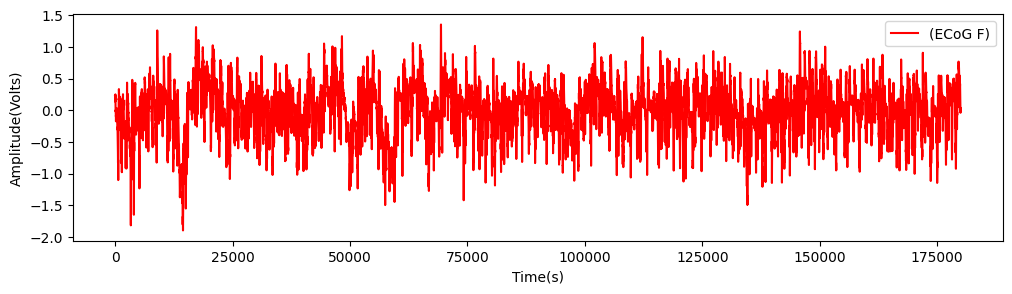

In [8]:
test_time_series = TimeSeries(biopac_channel=biopac_test_channel)
test_time_series.plot()

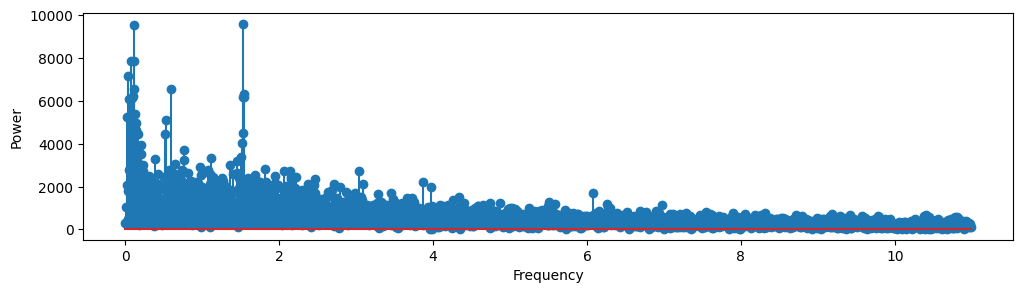

In [9]:
test_spectrum = Spectrum(test_time_series)
test_spectrum.plot(0, 12)

# Output Data Visualization

In [10]:
eeg_visualizer = EEGVisualiser()
eeg_visualizer.describe()

file_name mouse2.acq
	biopac_channel STIM
	biopac_channel EKG
	biopac_channel ECoG P
	biopac_channel ECoG F
file_name mouse1.acq
	biopac_channel STIM
	biopac_channel ECoG F
	biopac_channel ECoG P
file_name mouse4.acq
	biopac_channel STIM
	biopac_channel ECoG F
	biopac_channel ECoG P
	biopac_channel EKG
file_name mouse3.acq
	biopac_channel STIM
	biopac_channel ECoG F
	biopac_channel ECoG P


# With respect to mices

## Mice1

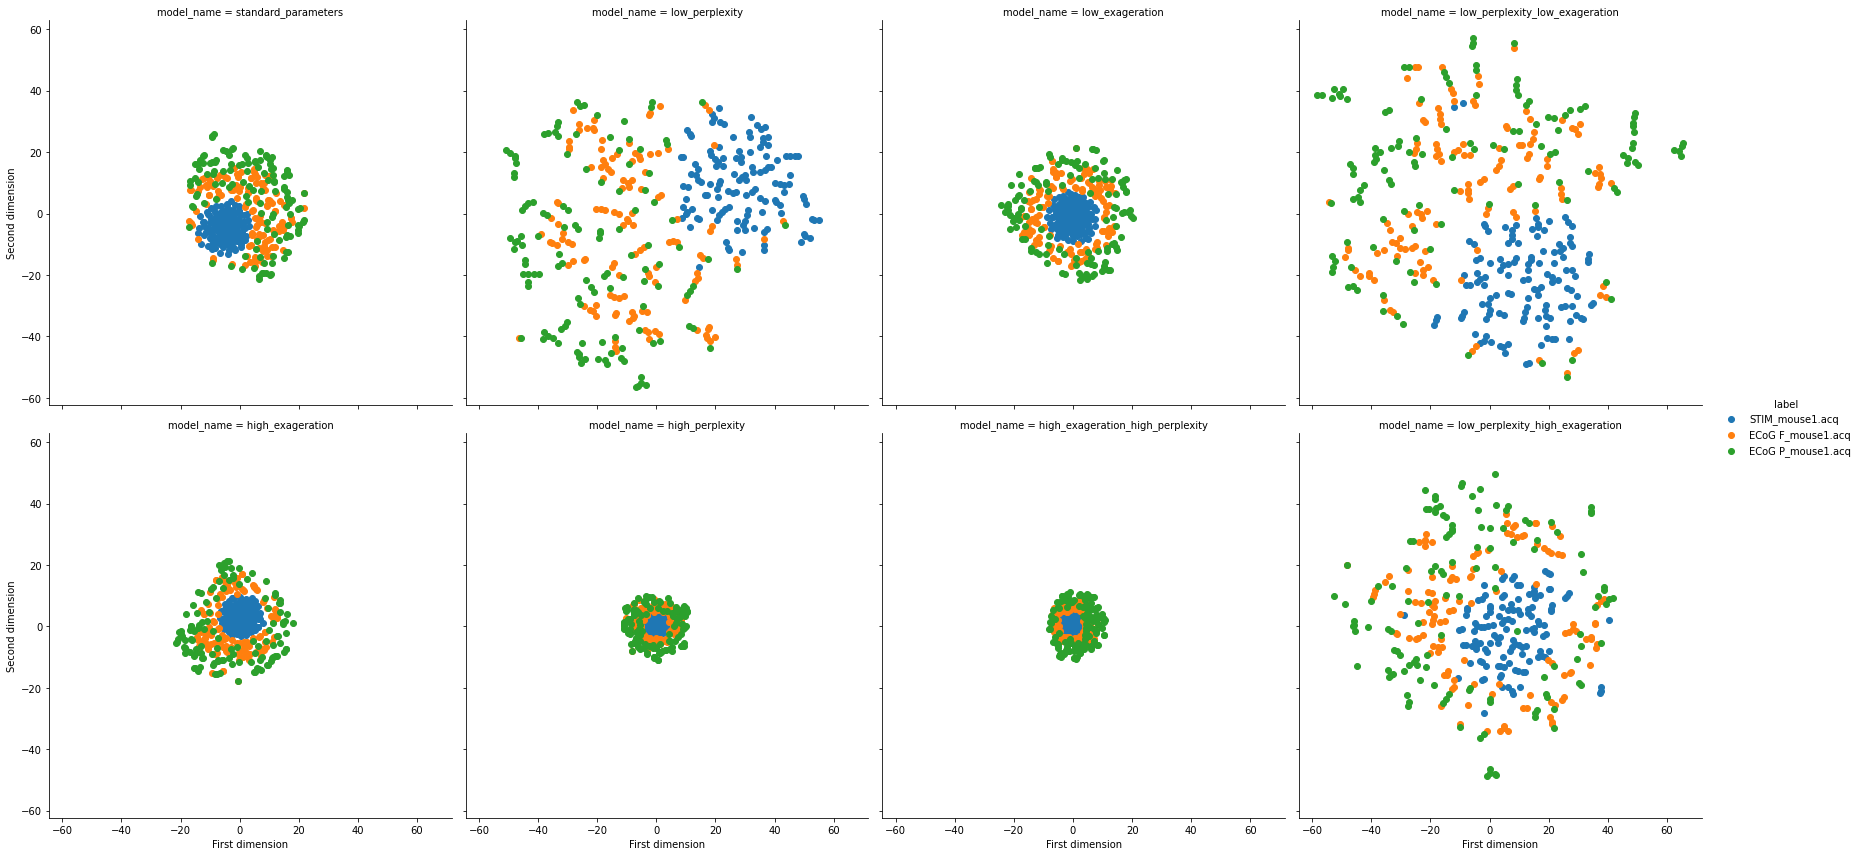

In [11]:
eeg_visualizer.create_windowed_data_set(files_name=['mouse1.acq'], eeg_channels=["ECoG F", "ECoG P", "STIM"])
eeg_visualizer.execute_t_snee()
x = eeg_visualizer.plot_t_sne()

## Mice2

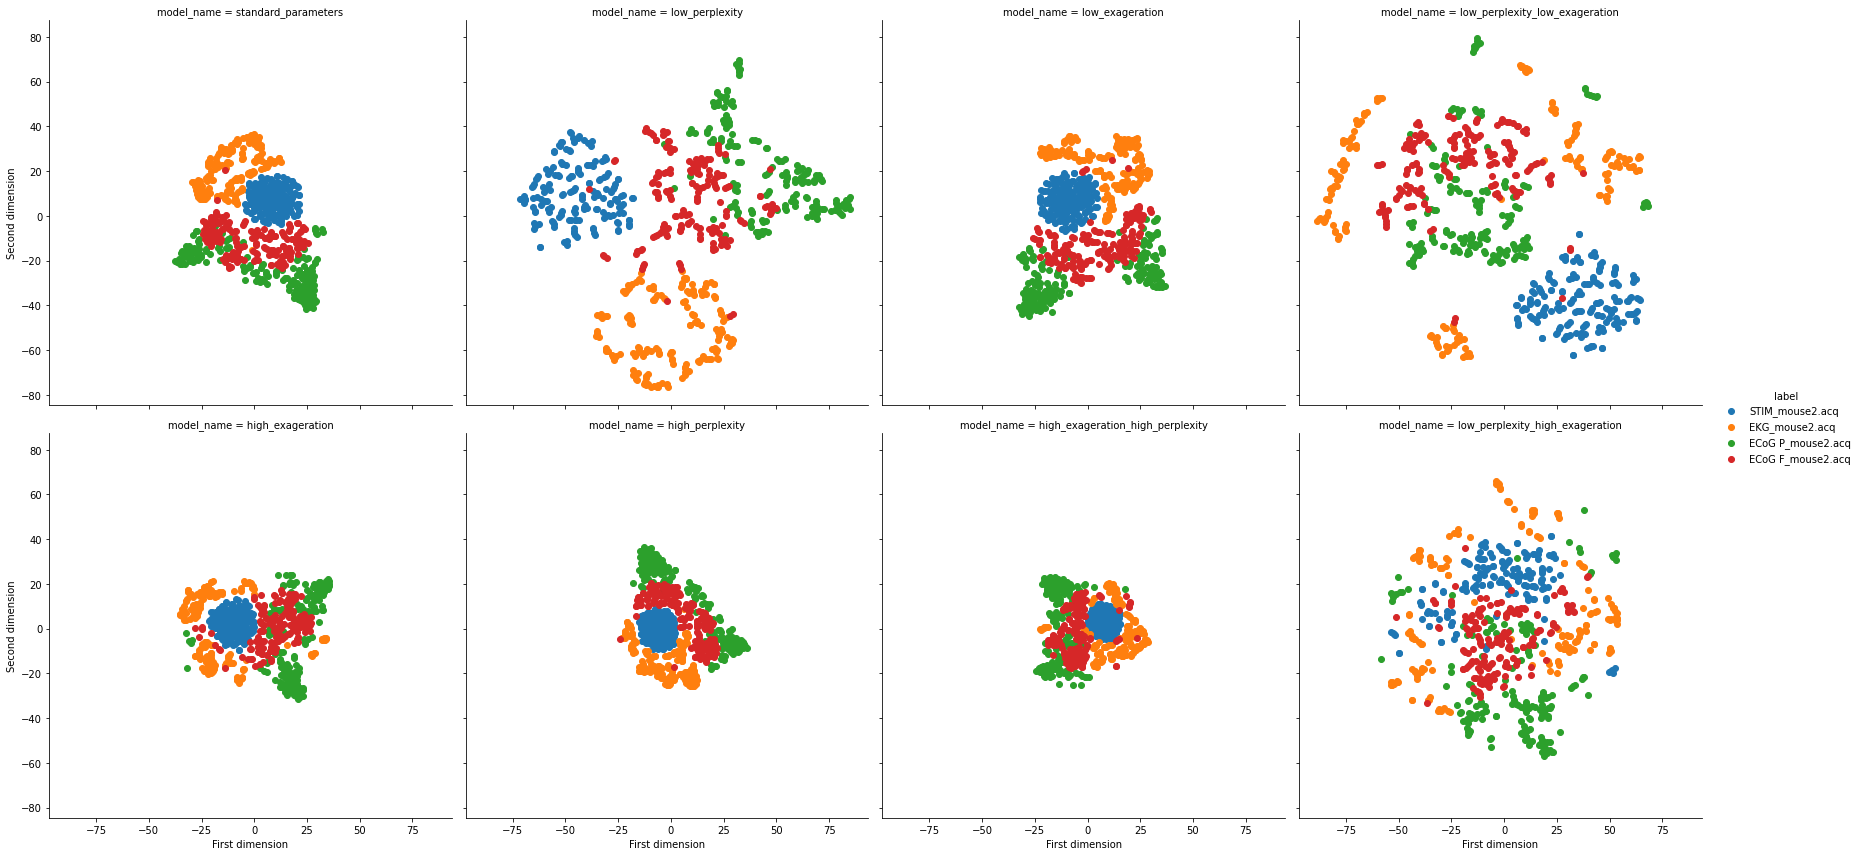

In [12]:
eeg_visualizer.create_windowed_data_set(files_name=['mouse2.acq'], eeg_channels=["ECoG F", "ECoG P", "STIM", "EKG"])
eeg_visualizer.execute_t_snee()
eeg_visualizer.plot_t_sne()

## Mice3

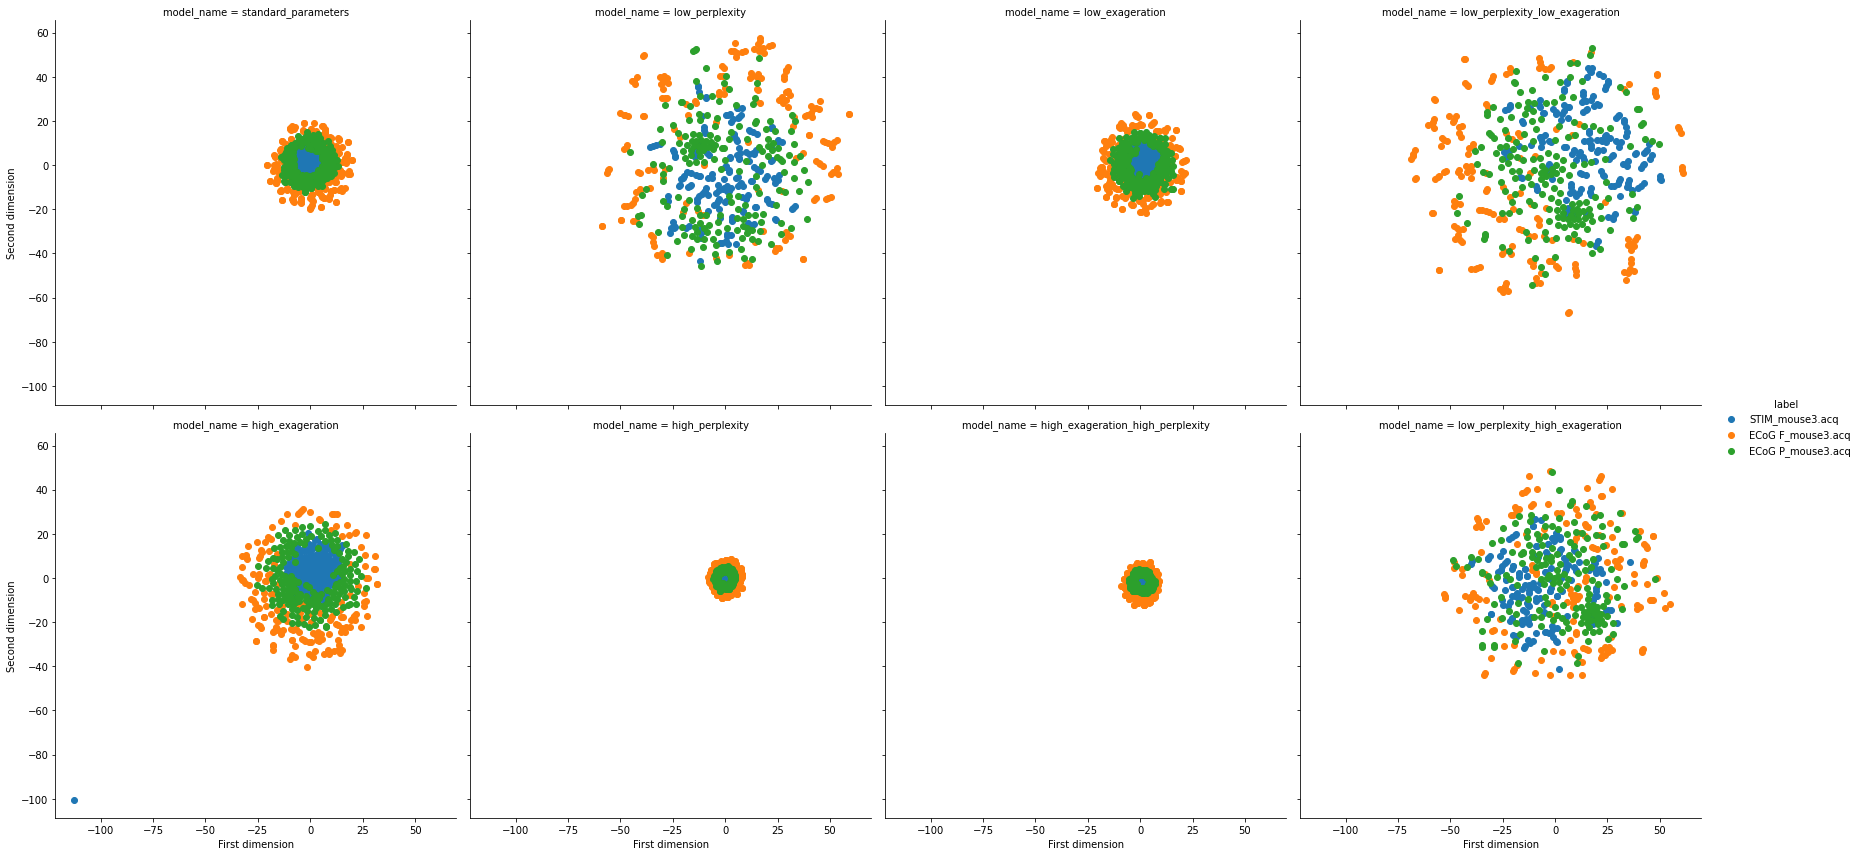

In [13]:
eeg_visualizer.create_windowed_data_set(files_name=['mouse3.acq'], eeg_channels=["ECoG F", "ECoG P", "STIM"])
eeg_visualizer.execute_t_snee()
eeg_visualizer.plot_t_sne()

## Mice4

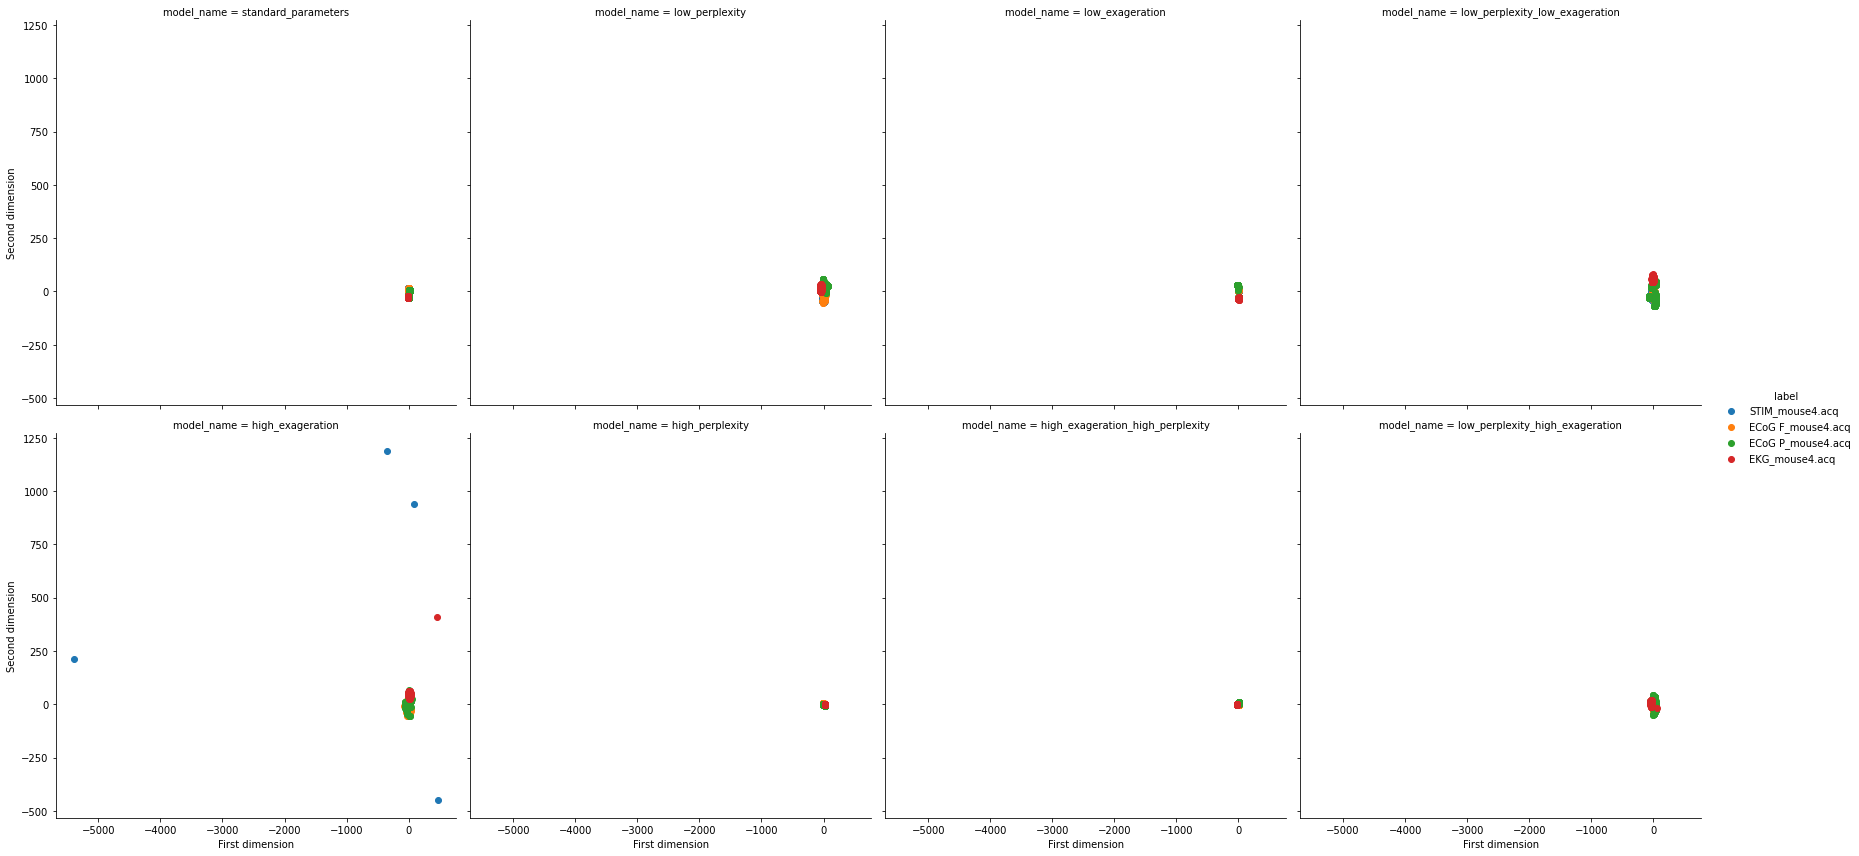

In [14]:
eeg_visualizer.create_windowed_data_set(files_name=['mouse4.acq'], eeg_channels=["ECoG F", "ECoG P", "STIM", "EKG"])
eeg_visualizer.execute_t_snee()
eeg_visualizer.plot_t_sne()

# All Mice

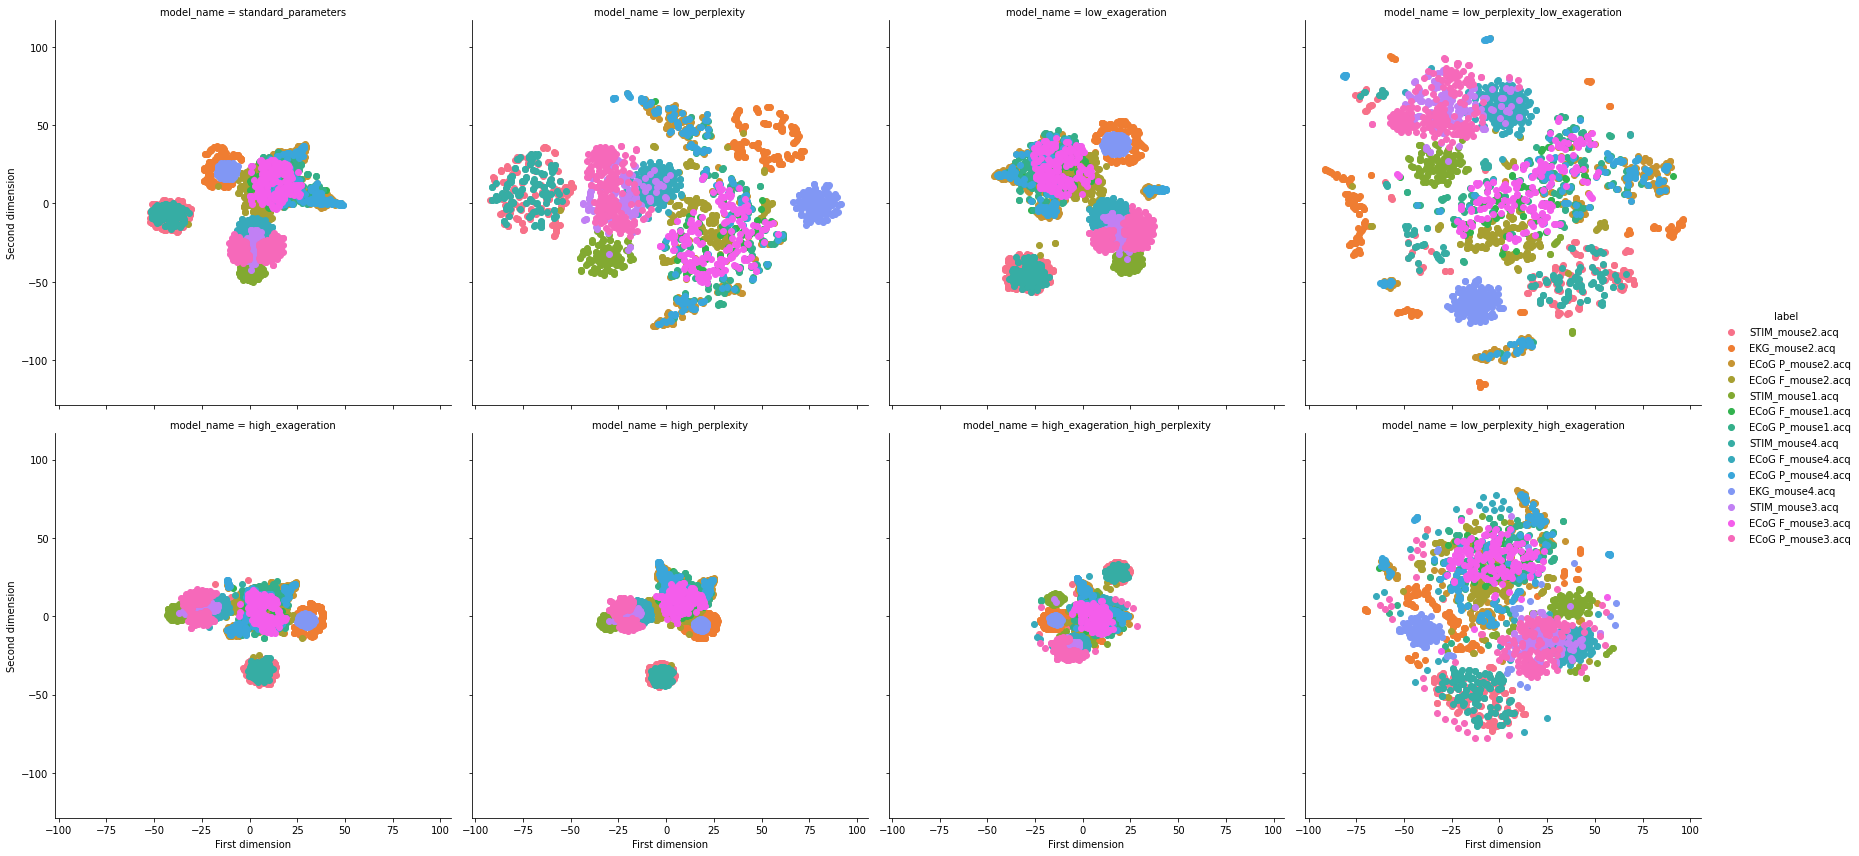

In [15]:
eeg_visualizer.create_windowed_data_set(eeg_channels=["ECoG F", "ECoG P", "STIM", "EKG"])
eeg_visualizer.execute_t_snee()
eeg_visualizer.plot_t_sne()

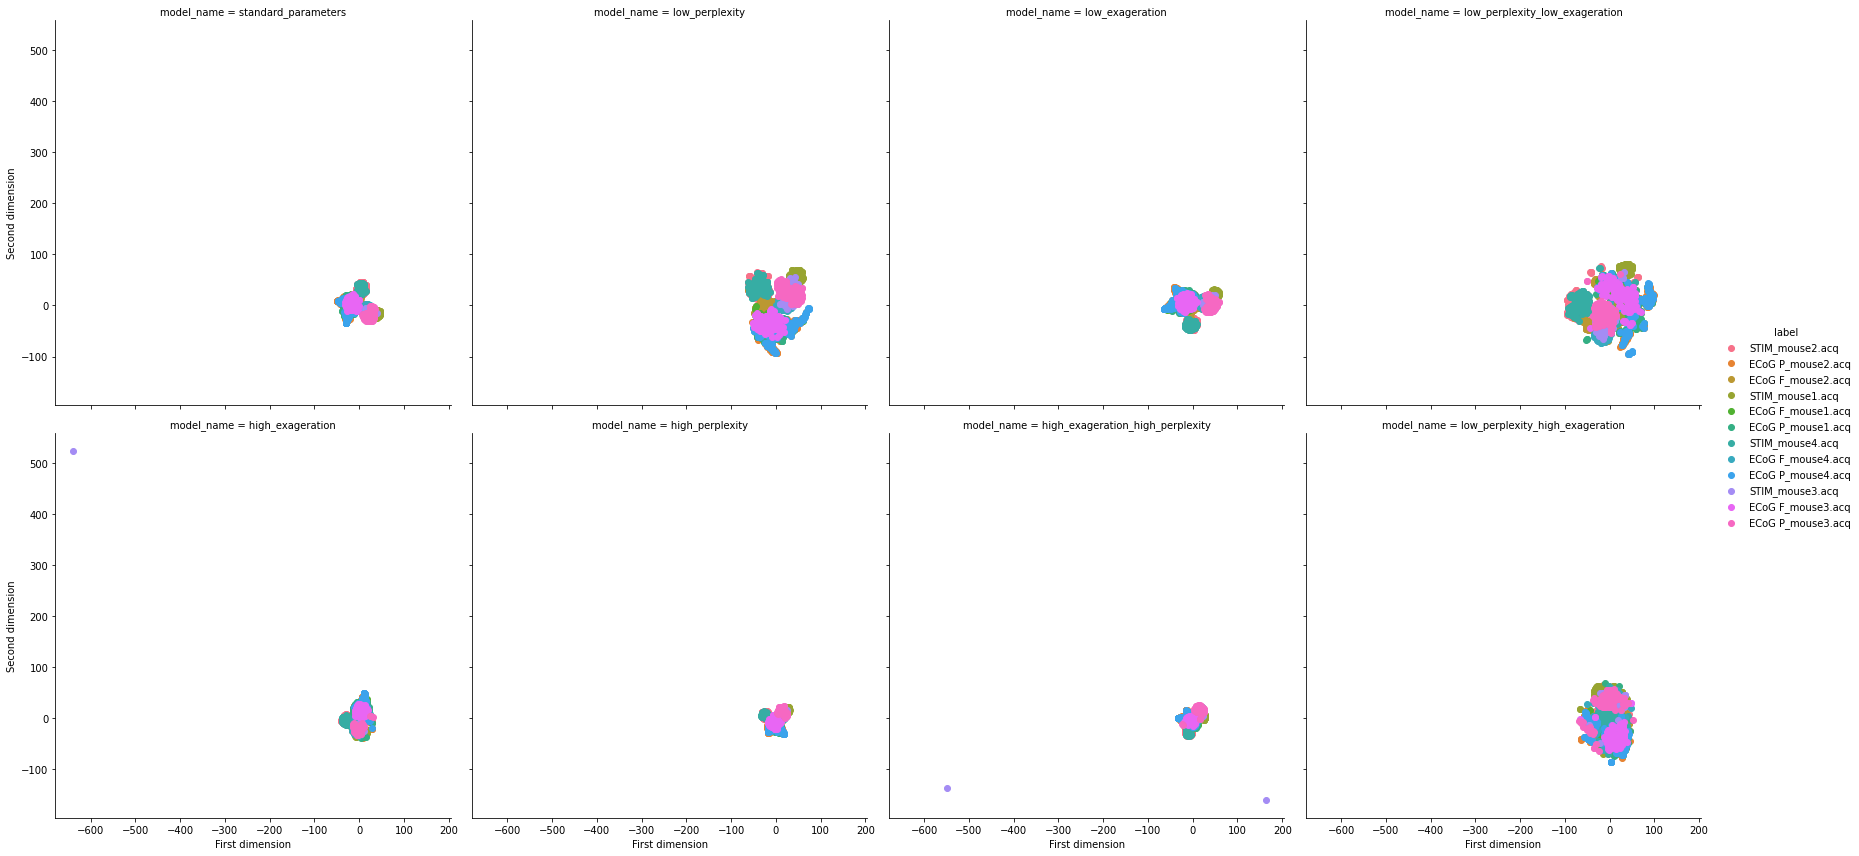

In [16]:
eeg_visualizer.create_windowed_data_set(eeg_channels=["ECoG F", "ECoG P", "STIM"])
eeg_visualizer.execute_t_snee()
eeg_visualizer.plot_t_sne()

# Pairs of mice with same acqusitioned channels

## Mouse1 and Mouse4

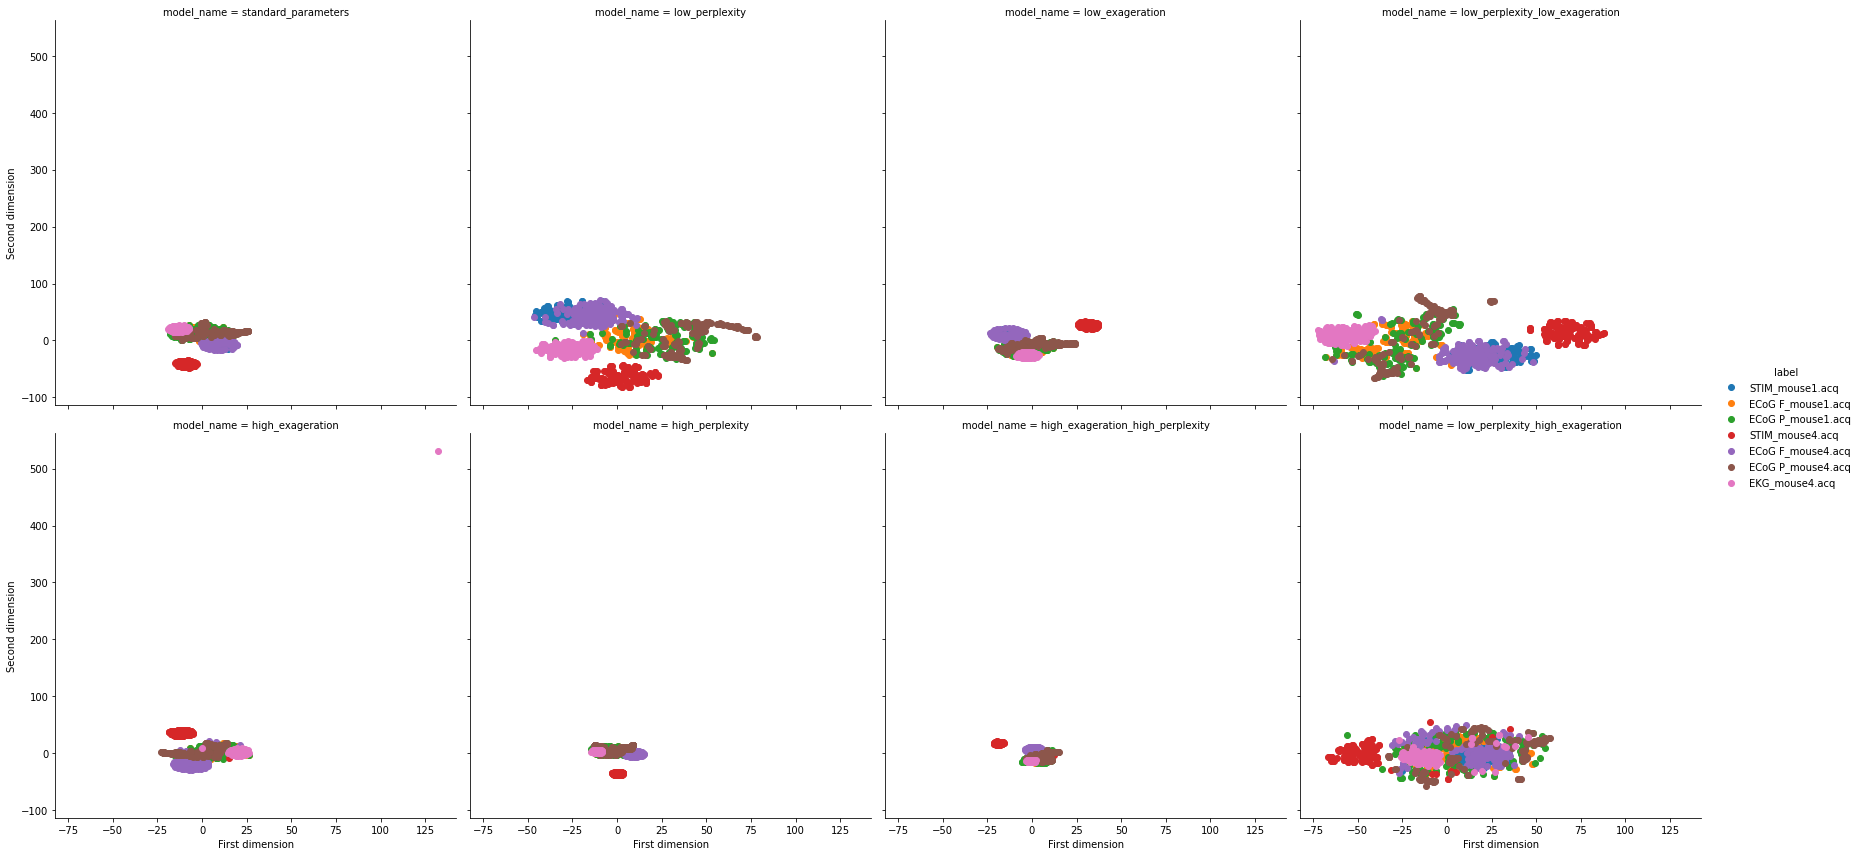

In [17]:
eeg_visualizer.create_windowed_data_set(files_name=["mouse1.acq", "mouse4.acq"])
eeg_visualizer.execute_t_snee()
eeg_visualizer.plot_t_sne()

## Mouse2 and Mouse3

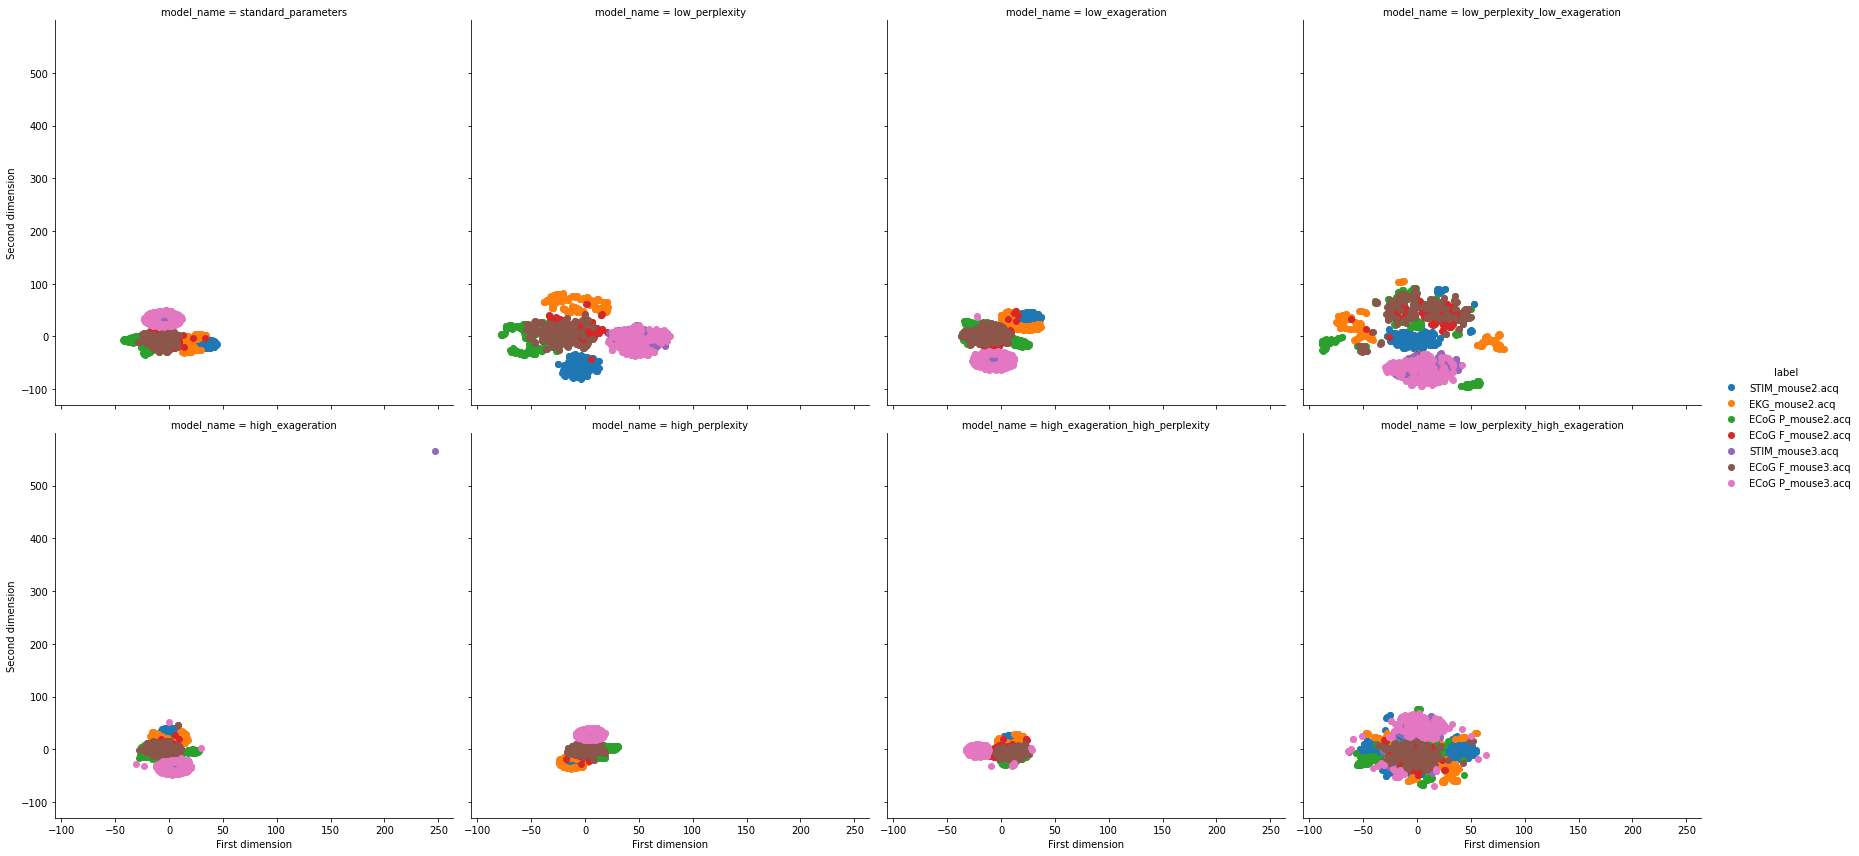

In [18]:
eeg_visualizer.create_windowed_data_set(files_name=["mouse2.acq", "mouse3.acq"])
eeg_visualizer.execute_t_snee()
eeg_visualizer.plot_t_sne()

# With respect to channels

## Frontal lobe

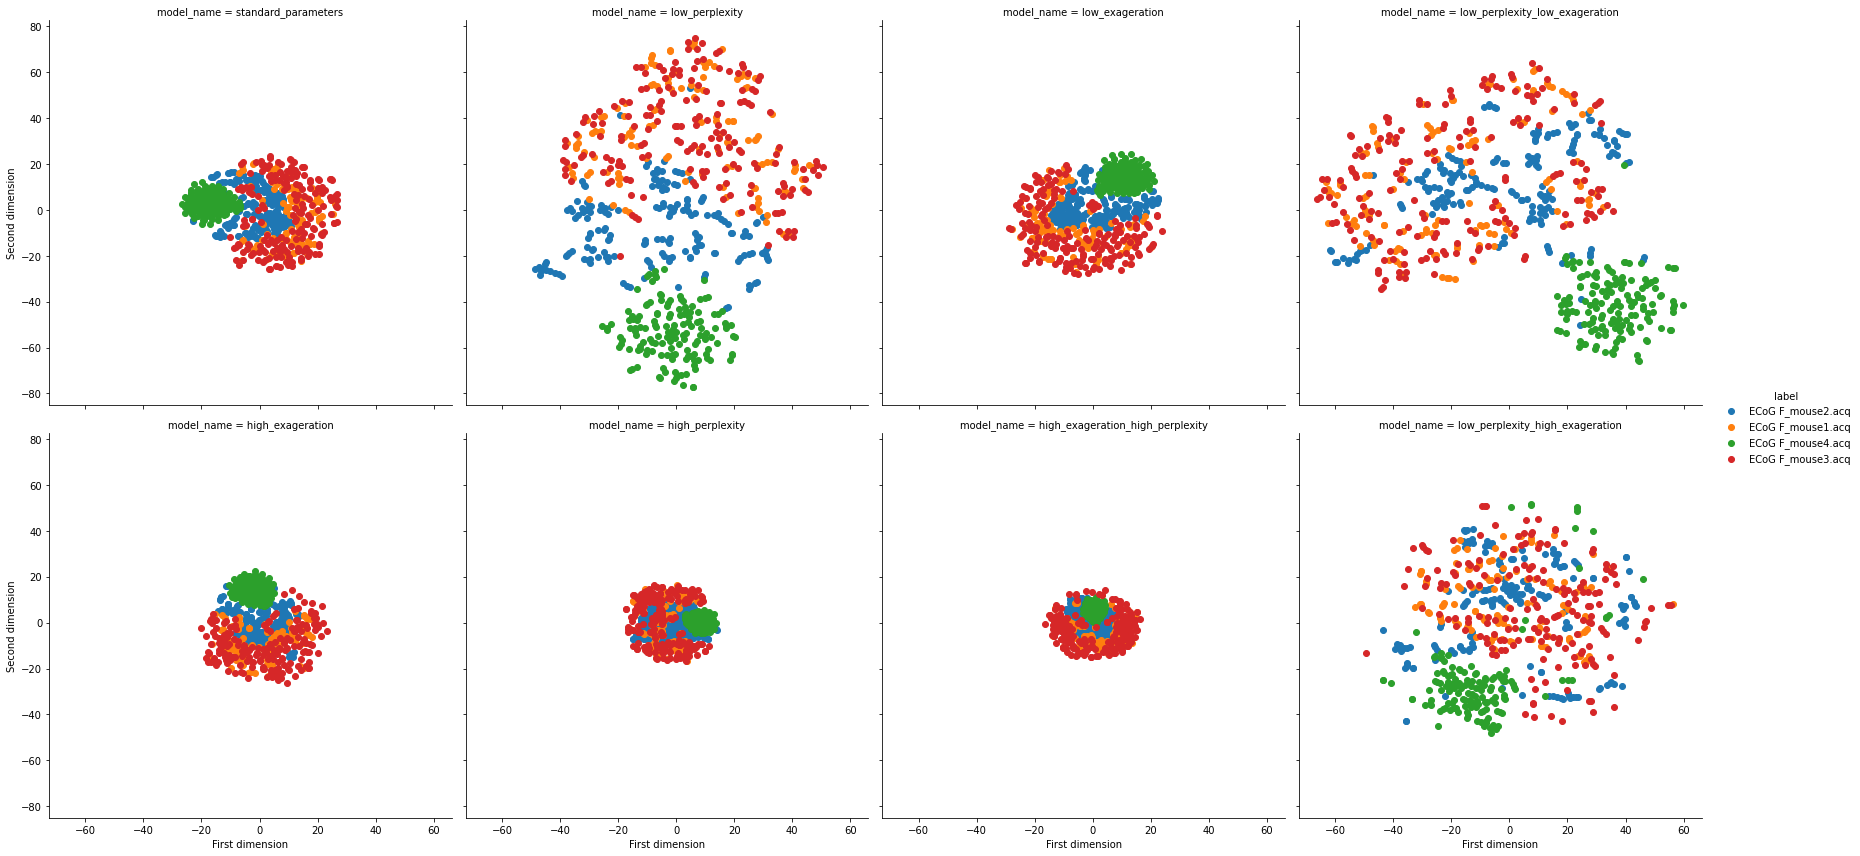

In [19]:
eeg_visualizer.create_windowed_data_set(eeg_channels=["ECoG F"])
eeg_visualizer.execute_t_snee()
eeg_visualizer.plot_t_sne()

## Parietal lobe

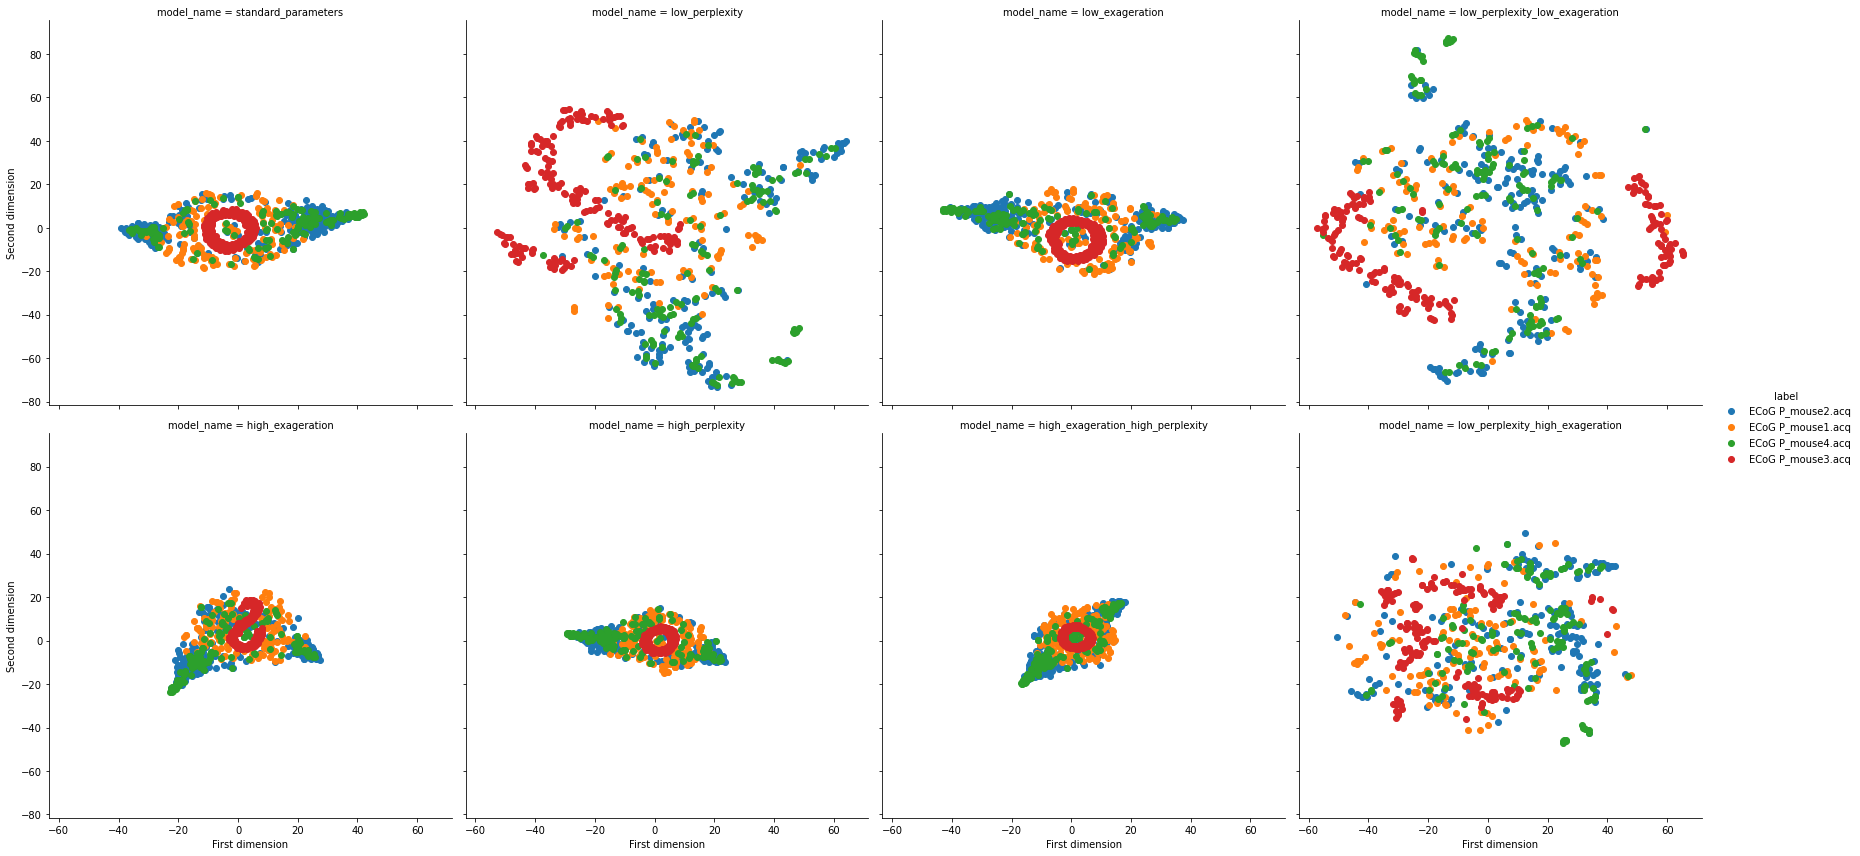

In [20]:
eeg_visualizer.create_windowed_data_set(eeg_channels=["ECoG P"])
eeg_visualizer.execute_t_snee()
eeg_visualizer.plot_t_sne()

## Both Frontal and Parietal lobes

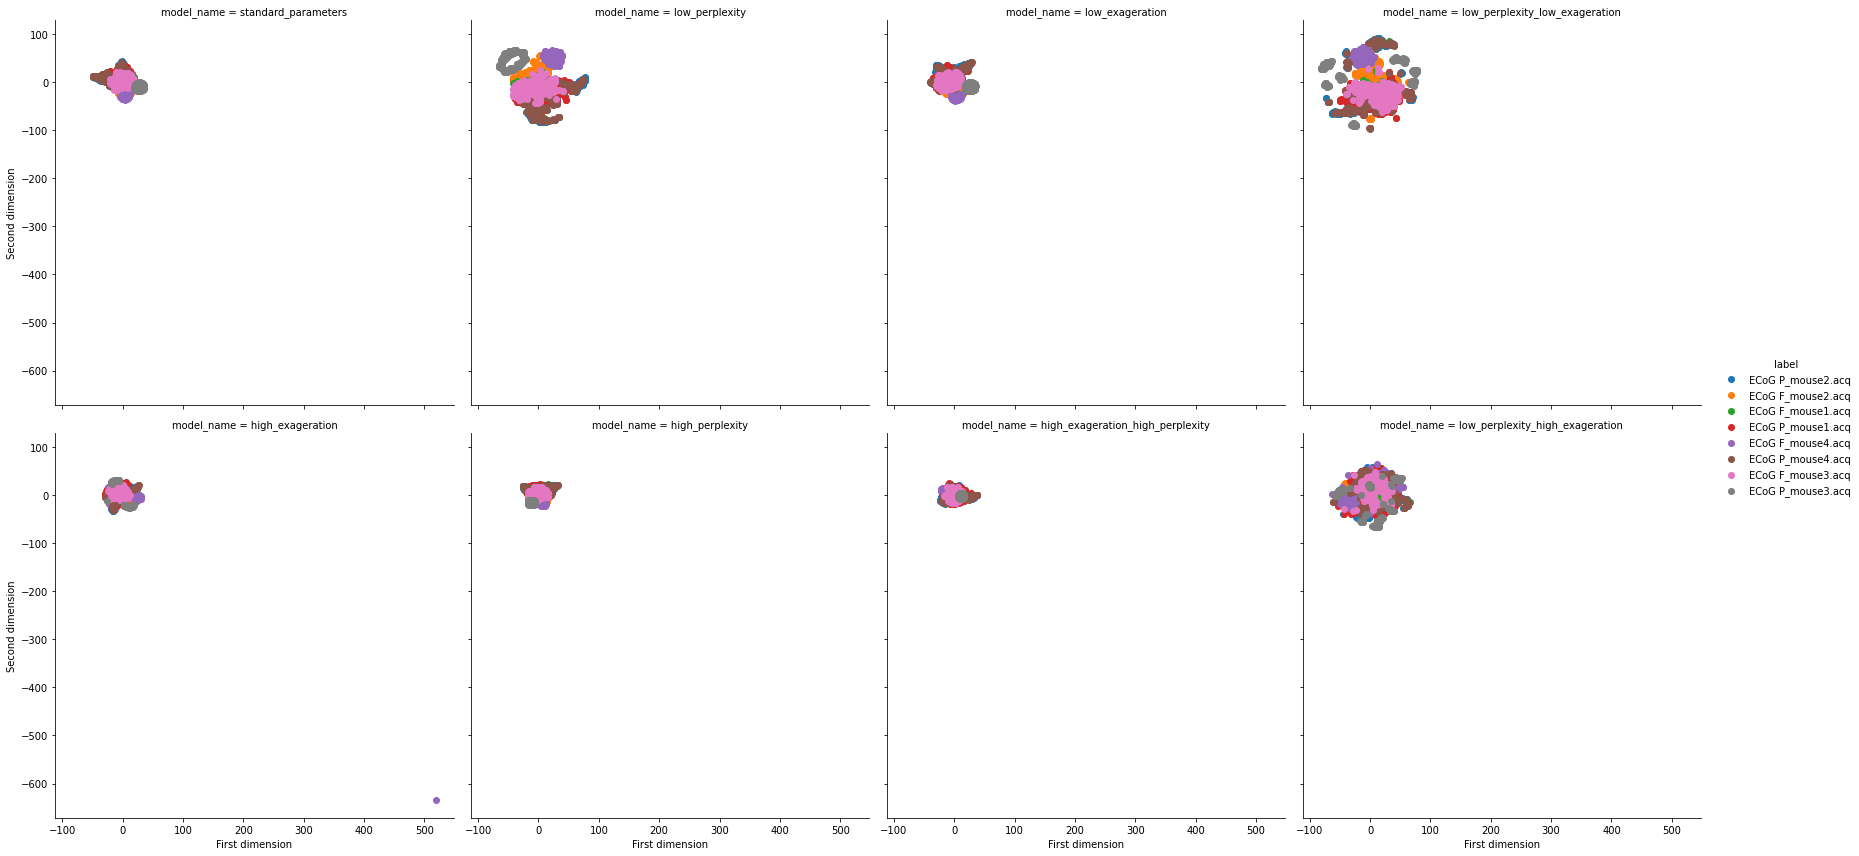

In [21]:
eeg_visualizer.create_windowed_data_set(eeg_channels=["ECoG P", "ECoG F"])
eeg_visualizer.execute_t_snee()
eeg_visualizer.plot_t_sne()

# Conclusions

```
We can observe similarities between:
    Mice1 and Mice3
    Mice2 and Mice4
```